<a href="https://colab.research.google.com/github/sujitpal/deeplearning-ai-examples/blob/master/tricks02_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## More tricks to improve CIFAR-10 classifier

Some more tricks that I came across in subsequent classes of the [Deep Learning with Pytorch](https://www.youtube.com/playlist?list=PLLHTzKZzVU9eaEyErdV26ikyolxOsz6mq) course from New York University, as listed below.

1. Wider network.
1. Deeper network.
1. Batch Norm.
1. Residual Connection.
1. Gradient Clipping.
1. Increase batch size.

Unlike the previous notebook, these are not listed neatly in a single slide, but are mentioned in passing. 

As with the previous notebook, we start with a baseline CNN with 3 layers, ReLU activation and Adam optimizer.


Residual: https://medium.com/analytics-vidhya/understanding-and-implementation-of-residual-networks-resnets-b80f9a507b9c


In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from torchsummary import summary

%matplotlib inline

In [2]:
TRAIN_IMAGES_DIR = "cifar10-train"
TEST_IMAGES_DIR = "cifar10-test"
MODEL_DIR = "models"

shutil.rmtree(MODEL_DIR, ignore_errors=True)
os.mkdir(MODEL_DIR)

In [3]:
CIFAR10_LABELS = [
  "aircraft", "automobile", "bird", "cat", "deer", 
  "dog", "frog", "horse", "ship", "truck"
]
idx2label = {i:x for i, x in enumerate(CIFAR10_LABELS)}
label2idx = {v:k for k, v in idx2label.items()}

len(idx2label), len(label2idx)

(10, 10)

### Baseline

* Data from `torchvision.datasets.CIFAR10`
* Model based on [Tensorflow CNN tutorial](https://www.tensorflow.org/tutorials/images/cnn)
    * 3 layer convolution/pool layers
    * 2 layer dense head
    * Adam optimizer

In [4]:
train_ds = torchvision.datasets.CIFAR10(TRAIN_IMAGES_DIR,
                                        transform=torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor()                      
                                        ]),
                                        train=True, download=True)
test_ds = torchvision.datasets.CIFAR10(TEST_IMAGES_DIR, 
                                       transform=torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor()                      
                                       ]),
                                       train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
BATCH_SIZE = 64

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

len(train_dl), len(test_dl)

(782, 157)

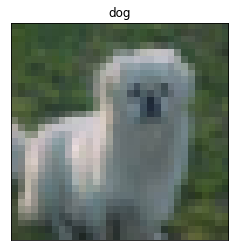

In [6]:
def show_data(image_label):
  image, label = image_label
  image = torch.transpose(torch.transpose(image, 0, 1), 1, 2)
  plt.title(idx2label[label])
  plt.xticks([])
  plt.yticks([])
  _ = plt.imshow(image)

show_data(train_ds[np.random.randint(low=0, high=len(train_dl))])

In [7]:
class Cifar10Classifier(nn.Module):
  def __init__(self, conv_block_sizes, ff_block_sizes,
               spatial_dropout=0, dense_dropout=0,
               input_channels=3, input_size=(32, 32), output_size=10):
    super(Cifar10Classifier, self).__init__()
    # convolution layers
    conv_layers = []
    for cid in range(len(conv_block_sizes)):
      conv_layers.append(nn.Sequential(
        nn.Conv2d(input_channels if cid == 0 else conv_block_sizes[cid - 1],
                  conv_block_sizes[cid], 
                  kernel_size=(3, 3), padding=(1, 1)),
        nn.ReLU(),
        nn.Dropout2d(p=spatial_dropout),
        nn.MaxPool2d(kernel_size=(2, 2))))
    self.conv_blocks = nn.ModuleList(conv_layers)
    # flatten
    self.flatten = nn.Flatten()
    # compute image size to figure out input size after flatten
    conv_output_width = input_size[0] // (2 ** len(conv_block_sizes))
    if conv_output_width < 1:
      raise ValueError("CNN pooling results in less than (1, 1) dimensions, reduce depth")
    conv_size = conv_output_width * conv_output_width * conv_block_sizes[cid]
    # linear layers
    linear_layers = []
    for fid in range(len(ff_block_sizes) + 1):
      linear_layers.append(nn.Sequential(
          nn.Linear(conv_size if fid == 0 else ff_block_sizes[fid - 1],
                    output_size if fid == len(ff_block_sizes) else ff_block_sizes[fid]),
          nn.Dropout(p=dense_dropout),
          nn.ReLU() if fid < len(ff_block_sizes) else nn.LogSoftmax(dim=1)
      ))
    self.linear_blocks = nn.ModuleList(linear_layers)

  def forward(self, x):
    for conv_block in self.conv_blocks:
      x = conv_block(x)
    x = self.flatten(x)
    for linear_block in self.linear_blocks:
      x = linear_block(x)
    return x


model_0 = Cifar10Classifier(
    conv_block_sizes=[32, 64, 64], 
    ff_block_sizes=[64, 10])
summary(model_0, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         Dropout2d-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
              ReLU-6           [-1, 64, 16, 16]               0
         Dropout2d-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,928
             ReLU-10             [-1, 64, 8, 8]               0
        Dropout2d-11             [-1, 64, 8, 8]               0
        MaxPool2d-12             [-1, 64, 4, 4]               0
          Flatten-13                 [-1, 1024]               0
           Linear-14                   

In [8]:
# self-test
x = torch.rand(10, 3, 32, 32)
y = model_0(x)
y.size()

torch.Size([10, 10])

In [9]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_0 = model_0.to(dev)

#### Training

In [10]:
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=LEARNING_RATE)

In [11]:
def train(model, train_dl, loss_fn, optimizer):
  model.train()
  train_losses, train_accs = [], []
  for batch in train_dl:
    images, labels = batch
    
    images = images.to(dev)
    labels = labels.to(dev)

    logits = model(images)
    loss = loss_fn(logits, labels)
    
    train_losses.append(loss.item())
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    train_accs.append(accuracy_score(preds, labels))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # if len(train_losses) > 5:
    #   break
  
  train_loss = sum(train_losses) / len(train_losses)
  train_acc = sum(train_accs) / len(train_accs)
  return train_loss, train_acc


# # self-test
# train_loss, train_acc = train(model_0, train_dl, loss_fn, optimizer)
# train_loss, train_acc

In [12]:
def validate(model, val_dl, loss_fn):
  model.eval()
  val_losses, val_accs = [], []
  for batch in val_dl:
    images, labels = batch

    images = images.to(dev)
    labels = labels.to(dev)

    with torch.no_grad():
      logits = model(images)
      loss = loss_fn(logits, labels)

    val_losses.append(loss.item())
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    val_accs.append(accuracy_score(preds, labels))

    # if len(val_losses) > 5:
    #   break

  val_loss = sum(val_losses) / len(val_losses)
  val_acc = sum(val_accs) / len(val_accs)
  return val_loss, val_acc


# # self-test
# val_loss, val_acc = validate(model_0, test_dl, loss_fn)
# val_loss, val_acc

In [13]:
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_0, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_0, test_dl, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch  1 | Train Loss: 1.834, Accuracy: 0.296 | Validation Loss: 1.554, Accuracy: 0.418
Epoch  2 | Train Loss: 1.418, Accuracy: 0.472 | Validation Loss: 1.306, Accuracy: 0.514
Epoch  3 | Train Loss: 1.242, Accuracy: 0.544 | Validation Loss: 1.192, Accuracy: 0.559
Epoch  4 | Train Loss: 1.140, Accuracy: 0.584 | Validation Loss: 1.152, Accuracy: 0.581
Epoch  5 | Train Loss: 1.058, Accuracy: 0.614 | Validation Loss: 1.057, Accuracy: 0.625
Epoch  6 | Train Loss: 0.996, Accuracy: 0.639 | Validation Loss: 1.091, Accuracy: 0.612
Epoch  7 | Train Loss: 0.946, Accuracy: 0.659 | Validation Loss: 1.048, Accuracy: 0.627
Epoch  8 | Train Loss: 0.896, Accuracy: 0.679 | Validation Loss: 1.026, Accuracy: 0.651
Epoch  9 | Train Loss: 0.858, Accuracy: 0.695 | Validation Loss: 0.995, Accuracy: 0.657
Epoch 10 | Train Loss: 0.821, Accuracy: 0.706 | Validation Loss: 0.973, Accuracy: 0.661


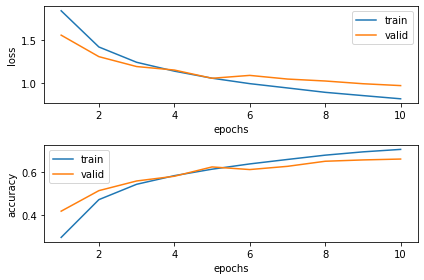

In [14]:
def plot_training_curves(train_losses, train_accs, val_losses, val_accs):
  plt.subplot(2, 1, 1)
  plt.plot(np.arange(NUM_EPOCHS)+1, train_losses, label="train")
  plt.plot(np.arange(NUM_EPOCHS)+1, val_losses, label="valid")
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.legend(loc="best")

  plt.subplot(2, 1, 2)
  plt.plot(np.arange(NUM_EPOCHS)+1, train_accs, label="train")
  plt.plot(np.arange(NUM_EPOCHS)+1, val_accs, label="valid")
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.legend(loc="best")

  plt.tight_layout()
  _ = plt.plot()


plot_training_curves(train_losses, train_accs, val_losses, val_accs)

#### Evaluation

In [15]:
def evaluate(model, test_dl):
  model.eval()
  true_values, pred_values = [], []
  for batch in test_dl:
    images, labels = batch
    images = images.to(dev)

    with torch.no_grad():
      logits = model(images)
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    labels = labels.numpy()

    true_values.extend(labels.tolist())
    pred_values.extend(preds.tolist())

  return true_values, pred_values


true_values, pred_values = evaluate(model_0, test_dl)

In [16]:
print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.662
--
confusion matrix
[[705  52  79  19  16   2  17  12  53  45]
 [ 10 901   0  10   4   0  19   2   7  47]
 [ 66  11 512  68 143  55 107  28   6   4]
 [ 14  17  84 370  63 180 227  27   8  10]
 [ 18   5  87  38 592  22 171  59   5   3]
 [ 15   2  60 168  47 574  73  48   4   9]
 [  5   9  22  37  27  15 881   0   2   2]
 [ 20   8  28  38 122  69  15 687   0  13]
 [ 74  92  19  20   6   2  28   3 724  32]
 [ 25 208   5  25   4   3  19  26  10 675]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.74      0.70      0.72      1000
  automobile       0.69      0.90      0.78      1000
        bird       0.57      0.51      0.54      1000
         cat       0.47      0.37      0.41      1000
        deer       0.58      0.59      0.58      1000
         dog       0.62      0.57      0.60      1000
        frog       0.57      0.88      0.69      1000
       horse       0.77      0.69      0.73      1000
        ship      

In [17]:
def write_metrics(true_values, pred_values, experiment_name, metric_filepath):
  fout = open(metric_filepath, "w")
  p, r, f, s = precision_recall_fscore_support(true_values, pred_values, average="micro")
  metrics_dict = {
    "precision": p, "recall": r, "f1-score": f, "support": s
  }
  metrics_dict["name"] = experiment_name
  fout.write(json.dumps(metrics_dict))
  fout.close()


metric_filepath = os.path.join(MODEL_DIR, "model_0.json")
write_metrics(true_values, pred_values, "baseline", metric_filepath)

### Wider Network

In [18]:
model_1 = Cifar10Classifier(
    conv_block_sizes=[32, 64, 64], 
    ff_block_sizes=[512, 10])
summary(model_1, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         Dropout2d-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
              ReLU-6           [-1, 64, 16, 16]               0
         Dropout2d-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,928
             ReLU-10             [-1, 64, 8, 8]               0
        Dropout2d-11             [-1, 64, 8, 8]               0
        MaxPool2d-12             [-1, 64, 4, 4]               0
          Flatten-13                 [-1, 1024]               0
           Linear-14                  [

In [19]:
model_1 = model_1.to(dev)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=LEARNING_RATE)

train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_1, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_1, test_dl, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch  1 | Train Loss: 1.997, Accuracy: 0.196 | Validation Loss: 1.780, Accuracy: 0.266
Epoch  2 | Train Loss: 1.633, Accuracy: 0.355 | Validation Loss: 1.422, Accuracy: 0.442
Epoch  3 | Train Loss: 1.377, Accuracy: 0.472 | Validation Loss: 1.341, Accuracy: 0.494
Epoch  4 | Train Loss: 1.247, Accuracy: 0.527 | Validation Loss: 1.233, Accuracy: 0.544
Epoch  5 | Train Loss: 1.152, Accuracy: 0.570 | Validation Loss: 1.142, Accuracy: 0.583
Epoch  6 | Train Loss: 1.070, Accuracy: 0.609 | Validation Loss: 1.085, Accuracy: 0.616
Epoch  7 | Train Loss: 0.965, Accuracy: 0.652 | Validation Loss: 1.072, Accuracy: 0.615
Epoch  8 | Train Loss: 0.870, Accuracy: 0.690 | Validation Loss: 0.993, Accuracy: 0.667
Epoch  9 | Train Loss: 0.785, Accuracy: 0.722 | Validation Loss: 0.924, Accuracy: 0.680
Epoch 10 | Train Loss: 0.721, Accuracy: 0.745 | Validation Loss: 0.901, Accuracy: 0.704


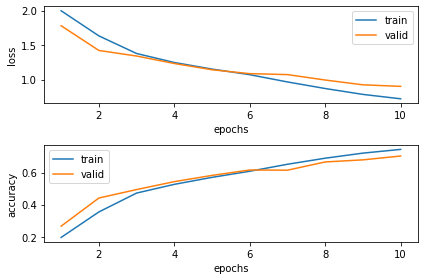

In [20]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [21]:
true_values, pred_values = evaluate(model_1, test_dl)

print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.704
--
confusion matrix
[[715  10 123  24  35   1  16  15  37  24]
 [ 28 788   6  11   4   1  28   2  20 112]
 [ 34   1 593  90 129  33  77  30  10   3]
 [  8   1  75 606  68 102  99  33   1   7]
 [  9   1  84  65 719  25  44  51   0   2]
 [  9   0  57 294  59 493  33  49   0   6]
 [  2   2  54  57  41  15 822   2   3   2]
 [ 12   0  35  59  88  48   6 748   0   4]
 [ 97  24  31  24   8   0   9   8 774  25]
 [ 31  67  10  35   8   1  30  16  16 786]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.76      0.71      0.74      1000
  automobile       0.88      0.79      0.83      1000
        bird       0.56      0.59      0.57      1000
         cat       0.48      0.61      0.54      1000
        deer       0.62      0.72      0.67      1000
         dog       0.69      0.49      0.57      1000
        frog       0.71      0.82      0.76      1000
       horse       0.78      0.75      0.77      1000
        ship      

In [22]:
metric_filepath = os.path.join(MODEL_DIR, "model_1.json")
write_metrics(true_values, pred_values, "wider_network", metric_filepath)

### Deeper Network

In [23]:
model_2 = Cifar10Classifier(
    conv_block_sizes=[32, 64, 64], 
    ff_block_sizes=[512, 256, 10])
summary(model_2, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         Dropout2d-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
              ReLU-6           [-1, 64, 16, 16]               0
         Dropout2d-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,928
             ReLU-10             [-1, 64, 8, 8]               0
        Dropout2d-11             [-1, 64, 8, 8]               0
        MaxPool2d-12             [-1, 64, 4, 4]               0
          Flatten-13                 [-1, 1024]               0
           Linear-14                  [

In [24]:
model_2 = model_2.to(dev)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=LEARNING_RATE)

train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_2, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_2, test_dl, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch  1 | Train Loss: 1.786, Accuracy: 0.321 | Validation Loss: 1.463, Accuracy: 0.447
Epoch  2 | Train Loss: 1.336, Accuracy: 0.516 | Validation Loss: 1.215, Accuracy: 0.575
Epoch  3 | Train Loss: 1.113, Accuracy: 0.606 | Validation Loss: 1.031, Accuracy: 0.637
Epoch  4 | Train Loss: 0.966, Accuracy: 0.661 | Validation Loss: 0.976, Accuracy: 0.666
Epoch  5 | Train Loss: 0.861, Accuracy: 0.702 | Validation Loss: 0.975, Accuracy: 0.678
Epoch  6 | Train Loss: 0.772, Accuracy: 0.733 | Validation Loss: 0.883, Accuracy: 0.705
Epoch  7 | Train Loss: 0.695, Accuracy: 0.758 | Validation Loss: 0.881, Accuracy: 0.708
Epoch  8 | Train Loss: 0.620, Accuracy: 0.784 | Validation Loss: 0.886, Accuracy: 0.725
Epoch  9 | Train Loss: 0.556, Accuracy: 0.806 | Validation Loss: 0.863, Accuracy: 0.727
Epoch 10 | Train Loss: 0.492, Accuracy: 0.826 | Validation Loss: 0.904, Accuracy: 0.729


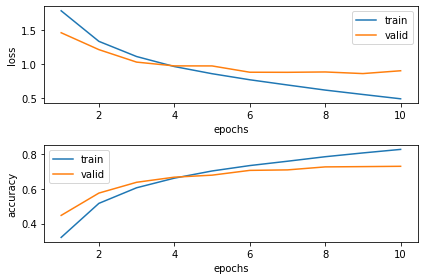

In [25]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [26]:
true_values, pred_values = evaluate(model_2, test_dl)

print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.729
--
confusion matrix
[[728  13  86  24  40   4   6  18  36  45]
 [ 19 789   5  10   8   1  13   3  12 140]
 [ 45   4 582  71 131  81  43  29   5   9]
 [  5   1  51 566  77 202  40  36   2  20]
 [ 10   1  43  84 745  24  19  69   1   4]
 [  5   0  38 206  38 646   9  52   1   5]
 [  1   7  32 103  59  20 769   4   1   4]
 [  6   1  12  64  52  63   2 781   1  18]
 [ 54  25  21  26   5   6   7   6 807  43]
 [ 25  26   5  23  10   2   2  13  17 877]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.81      0.73      0.77      1000
  automobile       0.91      0.79      0.85      1000
        bird       0.67      0.58      0.62      1000
         cat       0.48      0.57      0.52      1000
        deer       0.64      0.74      0.69      1000
         dog       0.62      0.65      0.63      1000
        frog       0.85      0.77      0.81      1000
       horse       0.77      0.78      0.78      1000
        ship      

In [27]:
metric_filepath = os.path.join(MODEL_DIR, "model_2.json")
write_metrics(true_values, pred_values, "deeper_network", metric_filepath)

### Add Batch Normalization (before ReLU)

There seems to be some controversy about where to put the BatchNorm in the model. According to Andrew Ng, it should be put before the non-linearity but according to Francois Chollet, the authors of the BatchNorm paper put this after the non-linerity. See [Stack Overflow discussion](https://stackoverflow.com/questions/47143521/where-to-apply-batch-normalization-on-standard-cnns#:~:text=Andrew%20Ng%20says%20that%20batch,BN%20after%20the%20activation%20layer.).

We will try both approaches to compare.

In [28]:
class Cifar10ClassifierBNR(nn.Module):
  def __init__(self, conv_block_sizes, ff_block_sizes,
               spatial_dropout=0, dense_dropout=0,
               input_channels=3, input_size=(32, 32), output_size=10):
    super(Cifar10ClassifierBNR, self).__init__()
    # convolution layers
    conv_layers = []
    for cid in range(len(conv_block_sizes)):
      conv_layers.append(nn.Sequential(
        nn.Conv2d(input_channels if cid == 0 else conv_block_sizes[cid - 1],
                  conv_block_sizes[cid], 
                  kernel_size=(3, 3), padding=(1, 1)),
        nn.BatchNorm2d(conv_block_sizes[cid]),
        nn.ReLU(),
        nn.Dropout2d(p=spatial_dropout),
        nn.MaxPool2d(kernel_size=(2, 2))))
    self.conv_blocks = nn.ModuleList(conv_layers)
    # flatten
    self.flatten = nn.Flatten()
    # compute image size to figure out input size after flatten
    conv_output_width = input_size[0] // (2 ** len(conv_block_sizes))
    if conv_output_width < 1:
      raise ValueError("CNN pooling results in less than (1, 1) dimensions, reduce depth")
    conv_size = conv_output_width * conv_output_width * conv_block_sizes[cid]
    # linear layers
    linear_layers = []
    for fid in range(len(ff_block_sizes) + 1):
      linear_layers.append(nn.Sequential(
          nn.Linear(conv_size if fid == 0 else ff_block_sizes[fid - 1],
                    output_size if fid == len(ff_block_sizes) else ff_block_sizes[fid]),
          nn.Dropout(p=dense_dropout),
          nn.ReLU() if fid < len(ff_block_sizes) else nn.LogSoftmax(dim=1)
      ))
    self.linear_blocks = nn.ModuleList(linear_layers)

  def forward(self, x):
    for conv_block in self.conv_blocks:
      x = conv_block(x)
    x = self.flatten(x)
    for linear_block in self.linear_blocks:
      x = linear_block(x)
    return x


model_3 = Cifar10ClassifierBNR(
    conv_block_sizes=[32, 64, 64], 
    ff_block_sizes=[64, 10])
summary(model_3, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         Dropout2d-4           [-1, 32, 32, 32]               0
         MaxPool2d-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
       BatchNorm2d-7           [-1, 64, 16, 16]             128
              ReLU-8           [-1, 64, 16, 16]               0
         Dropout2d-9           [-1, 64, 16, 16]               0
        MaxPool2d-10             [-1, 64, 8, 8]               0
           Conv2d-11             [-1, 64, 8, 8]          36,928
      BatchNorm2d-12             [-1, 64, 8, 8]             128
             ReLU-13             [-1, 64, 8, 8]               0
        Dropout2d-14             [-1, 6

In [29]:
model_3 = model_3.to(dev)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=LEARNING_RATE)

train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_3, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_3, test_dl, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch  1 | Train Loss: 1.402, Accuracy: 0.491 | Validation Loss: 1.097, Accuracy: 0.599
Epoch  2 | Train Loss: 0.941, Accuracy: 0.666 | Validation Loss: 0.967, Accuracy: 0.656
Epoch  3 | Train Loss: 0.804, Accuracy: 0.715 | Validation Loss: 1.001, Accuracy: 0.653
Epoch  4 | Train Loss: 0.720, Accuracy: 0.747 | Validation Loss: 1.160, Accuracy: 0.618
Epoch  5 | Train Loss: 0.650, Accuracy: 0.770 | Validation Loss: 0.814, Accuracy: 0.719
Epoch  6 | Train Loss: 0.591, Accuracy: 0.791 | Validation Loss: 0.837, Accuracy: 0.722
Epoch  7 | Train Loss: 0.541, Accuracy: 0.809 | Validation Loss: 0.745, Accuracy: 0.744
Epoch  8 | Train Loss: 0.495, Accuracy: 0.824 | Validation Loss: 0.771, Accuracy: 0.744
Epoch  9 | Train Loss: 0.455, Accuracy: 0.839 | Validation Loss: 0.746, Accuracy: 0.756
Epoch 10 | Train Loss: 0.417, Accuracy: 0.852 | Validation Loss: 0.816, Accuracy: 0.746


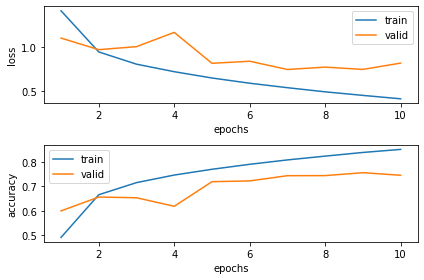

In [30]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [31]:
true_values, pred_values = evaluate(model_3, test_dl)

print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.746
--
confusion matrix
[[765  33  56  16  11   2   7   2  87  21]
 [  7 888   5   4   1   1   9   1  30  54]
 [ 61   3 709  37  38  20  91  14  21   6]
 [ 14   4  83 598  37  74 129  15  37   9]
 [ 14   3  88  66 671   6 105  26  19   2]
 [ 12   4  57 277  37 496  59  31  17  10]
 [  4   3  39  35   7   0 899   1   9   3]
 [ 17   5  62  51  72  36  13 719   7  18]
 [ 40  19   4  10   4   1   6   0 909   7]
 [ 16  82   9  17   1   0  12   9  52 802]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.81      0.77      0.78      1000
  automobile       0.85      0.89      0.87      1000
        bird       0.64      0.71      0.67      1000
         cat       0.54      0.60      0.57      1000
        deer       0.76      0.67      0.71      1000
         dog       0.78      0.50      0.61      1000
        frog       0.68      0.90      0.77      1000
       horse       0.88      0.72      0.79      1000
        ship      

In [32]:
metric_filepath = os.path.join(MODEL_DIR, "model_3.json")
write_metrics(true_values, pred_values, "batchnorm_before_relu", metric_filepath)

### Add Batch Normalization (after ReLU)

In [33]:
class Cifar10ClassifierRBN(nn.Module):
  def __init__(self, conv_block_sizes, ff_block_sizes,
               spatial_dropout=0, dense_dropout=0,
               input_channels=3, input_size=(32, 32), output_size=10):
    super(Cifar10ClassifierRBN, self).__init__()
    # convolution layers
    conv_layers = []
    for cid in range(len(conv_block_sizes)):
      conv_layers.append(nn.Sequential(
        nn.Conv2d(input_channels if cid == 0 else conv_block_sizes[cid - 1],
                  conv_block_sizes[cid], 
                  kernel_size=(3, 3), padding=(1, 1)),
        nn.ReLU(),
        nn.BatchNorm2d(conv_block_sizes[cid]),
        nn.Dropout2d(p=spatial_dropout),
        nn.MaxPool2d(kernel_size=(2, 2))))
    self.conv_blocks = nn.ModuleList(conv_layers)
    # flatten
    self.flatten = nn.Flatten()
    # compute image size to figure out input size after flatten
    conv_output_width = input_size[0] // (2 ** len(conv_block_sizes))
    if conv_output_width < 1:
      raise ValueError("CNN pooling results in less than (1, 1) dimensions, reduce depth")
    conv_size = conv_output_width * conv_output_width * conv_block_sizes[cid]
    # linear layers
    linear_layers = []
    for fid in range(len(ff_block_sizes) + 1):
      linear_layers.append(nn.Sequential(
          nn.Linear(conv_size if fid == 0 else ff_block_sizes[fid - 1],
                    output_size if fid == len(ff_block_sizes) else ff_block_sizes[fid]),
          nn.Dropout(p=dense_dropout),
          nn.ReLU() if fid < len(ff_block_sizes) else nn.LogSoftmax(dim=1)
      ))
    self.linear_blocks = nn.ModuleList(linear_layers)

  def forward(self, x):
    for conv_block in self.conv_blocks:
      x = conv_block(x)
    x = self.flatten(x)
    for linear_block in self.linear_blocks:
      x = linear_block(x)
    return x


model_4 = Cifar10ClassifierRBN(
    conv_block_sizes=[32, 64, 64], 
    ff_block_sizes=[64, 10])
summary(model_4, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
         Dropout2d-4           [-1, 32, 32, 32]               0
         MaxPool2d-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
              ReLU-7           [-1, 64, 16, 16]               0
       BatchNorm2d-8           [-1, 64, 16, 16]             128
         Dropout2d-9           [-1, 64, 16, 16]               0
        MaxPool2d-10             [-1, 64, 8, 8]               0
           Conv2d-11             [-1, 64, 8, 8]          36,928
             ReLU-12             [-1, 64, 8, 8]               0
      BatchNorm2d-13             [-1, 64, 8, 8]             128
        Dropout2d-14             [-1, 6

In [34]:
model_4 = model_4.to(dev)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=LEARNING_RATE)

train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_4, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_4, test_dl, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch  1 | Train Loss: 1.295, Accuracy: 0.531 | Validation Loss: 0.976, Accuracy: 0.654
Epoch  2 | Train Loss: 0.830, Accuracy: 0.708 | Validation Loss: 0.934, Accuracy: 0.676
Epoch  3 | Train Loss: 0.672, Accuracy: 0.763 | Validation Loss: 0.856, Accuracy: 0.707
Epoch  4 | Train Loss: 0.572, Accuracy: 0.799 | Validation Loss: 0.745, Accuracy: 0.747
Epoch  5 | Train Loss: 0.499, Accuracy: 0.824 | Validation Loss: 0.965, Accuracy: 0.677
Epoch  6 | Train Loss: 0.432, Accuracy: 0.848 | Validation Loss: 0.927, Accuracy: 0.715
Epoch  7 | Train Loss: 0.372, Accuracy: 0.869 | Validation Loss: 0.821, Accuracy: 0.747
Epoch  8 | Train Loss: 0.323, Accuracy: 0.885 | Validation Loss: 0.883, Accuracy: 0.743
Epoch  9 | Train Loss: 0.279, Accuracy: 0.901 | Validation Loss: 0.854, Accuracy: 0.764
Epoch 10 | Train Loss: 0.252, Accuracy: 0.910 | Validation Loss: 1.003, Accuracy: 0.746


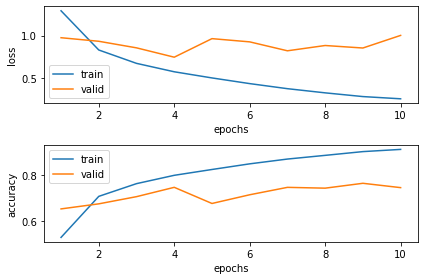

In [35]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [36]:
true_values, pred_values = evaluate(model_4, test_dl)

print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.746
--
confusion matrix
[[807  12  60  11  11   1  10   2  65  21]
 [ 23 891   5   4   2   2   5   0  16  52]
 [ 65   4 730  34  50  18  48  26  16   9]
 [ 32  12 118 530  56  67  84  48  26  27]
 [ 30   4  75  44 704  12  61  55  13   2]
 [ 17   9 107 181  47 499  28  66  27  19]
 [  8  11  40  45  20   7 842   9  13   5]
 [ 29   7  47  30  38  24   8 803   3  11]
 [ 55  34  12   3   2   0   3  10 858  23]
 [ 49  96   7   5   4   0   5   7  31 796]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.72      0.81      0.76      1000
  automobile       0.82      0.89      0.86      1000
        bird       0.61      0.73      0.66      1000
         cat       0.60      0.53      0.56      1000
        deer       0.75      0.70      0.73      1000
         dog       0.79      0.50      0.61      1000
        frog       0.77      0.84      0.80      1000
       horse       0.78      0.80      0.79      1000
        ship      

In [37]:
metric_filepath = os.path.join(MODEL_DIR, "model_4.json")
write_metrics(true_values, pred_values, "batchnorm_after_relu", metric_filepath)

### Residual Connection

According to [Residual Networks: Implementing ResNets in Pytorch](https://towardsdatascience.com/residual-network-implementing-resnet-a7da63c7b278), a basic ResNet block is composed of two layers of 3x3 conv/batchnorm/relu. Our original model has 3 layers, so we will convert the last two convolution layers into a ResNet block. The shortcut (the "identity" path in the figure below) will pass the input through a 1x1 convolution so the addition `F(x) + x` can be done.

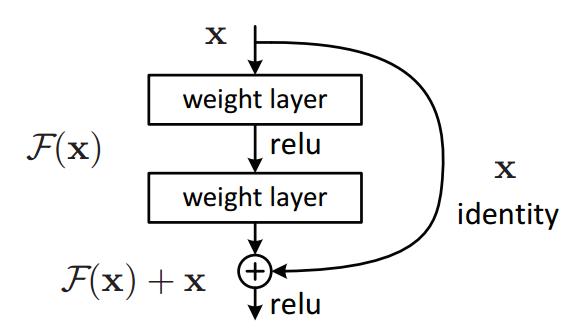

Note that this is just one of the configurations possible with ResNet, other configurations are possible as indicated in [Residual Networks: Building blocks of ResNet](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec).

In [38]:
class Cifar10ClassifierRes(nn.Module):
  def __init__(self, conv_block_sizes, ff_block_sizes,
               spatial_dropout=0, dense_dropout=0,
               input_channels=3, input_size=(32, 32), output_size=10):
    super(Cifar10ClassifierRes, self).__init__()
    # convolution layers
    conv_layers, shortcuts, poolings = [], [], []
    for cid in range(len(conv_block_sizes)):
      conv_layers.append(nn.Sequential(
        nn.Conv2d(input_channels if cid == 0 else conv_block_sizes[cid - 1],
                  conv_block_sizes[cid], 
                  kernel_size=(3, 3), padding=(1, 1)),
        # batchnorm before relu gives better results
        nn.BatchNorm2d(conv_block_sizes[cid]),
        nn.ReLU(),
        nn.Conv2d(conv_block_sizes[cid], conv_block_sizes[cid],
                  kernel_size=(3, 3), padding=(1, 1)),
        nn.BatchNorm2d(conv_block_sizes[cid]),
        nn.Dropout2d(p=spatial_dropout)))
      shortcuts.append(nn.Sequential(
        nn.Conv2d(input_channels if cid == 0 else conv_block_sizes[cid - 1], 
                  conv_block_sizes[cid], 
                  kernel_size=(1, 1))))
      poolings.append(nn.MaxPool2d(kernel_size=(2, 2)))

    self.conv_blocks = nn.ModuleList(conv_layers)
    self.shortcut_paths = nn.ModuleList(shortcuts)
    self.pool_ops = nn.ModuleList(poolings)

    # flatten
    self.flatten = nn.Flatten()
    # compute image size to figure out input size after flatten
    conv_output_width = input_size[0] // (2 ** len(conv_block_sizes))
    if conv_output_width < 1:
      raise ValueError("CNN pooling results in less than (1, 1) dimensions, reduce depth")
    conv_size = conv_output_width * conv_output_width * conv_block_sizes[cid]
    # linear layers
    linear_layers = []
    for fid in range(len(ff_block_sizes) + 1):
      linear_layers.append(nn.Sequential(
          nn.Linear(conv_size if fid == 0 else ff_block_sizes[fid - 1],
                    output_size if fid == len(ff_block_sizes) else ff_block_sizes[fid]),
          nn.Dropout(p=dense_dropout),
          nn.ReLU() if fid < len(ff_block_sizes) else nn.LogSoftmax(dim=1)
      ))
    self.linear_blocks = nn.ModuleList(linear_layers)

  def forward(self, x):
    for conv_block, shortcut_path, pool_op in zip(
        self.conv_blocks, self.shortcut_paths, self.pool_ops):
      x = conv_block(x) + shortcut_path(x)
      x = F.relu(x)
      x = pool_op(x)
    x = self.flatten(x)
    for linear_block in self.linear_blocks:
      x = linear_block(x)
    return x


model_5 = Cifar10ClassifierRes(
    conv_block_sizes=[32, 64, 64], 
    ff_block_sizes=[64, 10])
summary(model_5, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         Dropout2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]             128
         MaxPool2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
      BatchNorm2d-10           [-1, 64, 16, 16]             128
             ReLU-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,928
      BatchNorm2d-13           [-1, 64, 16, 16]             128
        Dropout2d-14           [-1, 64,

In [39]:
model_5 = model_5.to(dev)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_5.parameters(), lr=LEARNING_RATE)

train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_5, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_5, test_dl, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch  1 | Train Loss: 1.378, Accuracy: 0.485 | Validation Loss: 1.166, Accuracy: 0.586
Epoch  2 | Train Loss: 0.864, Accuracy: 0.694 | Validation Loss: 0.872, Accuracy: 0.690
Epoch  3 | Train Loss: 0.689, Accuracy: 0.758 | Validation Loss: 0.699, Accuracy: 0.760
Epoch  4 | Train Loss: 0.565, Accuracy: 0.803 | Validation Loss: 0.793, Accuracy: 0.735
Epoch  5 | Train Loss: 0.480, Accuracy: 0.835 | Validation Loss: 0.930, Accuracy: 0.715
Epoch  6 | Train Loss: 0.415, Accuracy: 0.855 | Validation Loss: 0.628, Accuracy: 0.798
Epoch  7 | Train Loss: 0.347, Accuracy: 0.878 | Validation Loss: 0.679, Accuracy: 0.787
Epoch  8 | Train Loss: 0.295, Accuracy: 0.898 | Validation Loss: 0.640, Accuracy: 0.801
Epoch  9 | Train Loss: 0.248, Accuracy: 0.913 | Validation Loss: 0.712, Accuracy: 0.791
Epoch 10 | Train Loss: 0.208, Accuracy: 0.927 | Validation Loss: 0.666, Accuracy: 0.809


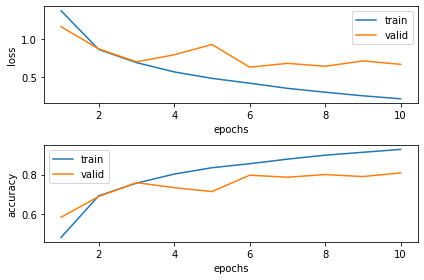

In [40]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [41]:
true_values, pred_values = evaluate(model_5, test_dl)

print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.809
--
confusion matrix
[[852  17  31   8   7   0   0  11  42  32]
 [  9 912   0   7   2   0   0   1  14  55]
 [ 74   3 717  43  50  30  49  17  11   6]
 [ 18   2  62 682  33 109  44  21  13  16]
 [ 13   7  61  59 742  17  32  67   2   0]
 [ 12   2  65 135  23 699  21  37   2   4]
 [  9   6  53  45  18   8 847   3   5   6]
 [ 14   2  17  27  19  29   8 872   2  10]
 [ 49  24   2  11   0   2   2   1 878  31]
 [ 19  62   1   6   0   0   2   4  19 887]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.80      0.85      0.82      1000
  automobile       0.88      0.91      0.90      1000
        bird       0.71      0.72      0.71      1000
         cat       0.67      0.68      0.67      1000
        deer       0.83      0.74      0.78      1000
         dog       0.78      0.70      0.74      1000
        frog       0.84      0.85      0.84      1000
       horse       0.84      0.87      0.86      1000
        ship      

In [42]:
metric_filepath = os.path.join(MODEL_DIR, "model_5.json")
write_metrics(true_values, pred_values, "residual_conn", metric_filepath)

### Gradient Clipping

More popular in RNNs, and wasn't actually mentioned in the lectures, but I learned about it in passing and was curious to see if it might have an effect on CNNs.

This is achieved in the training loop by clipping the gradients (between `loss.backward()` and `optimizer.step()`.

In [43]:
model_6 = Cifar10Classifier(
    conv_block_sizes=[32, 64, 64], 
    ff_block_sizes=[64, 10])
summary(model_6, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         Dropout2d-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
              ReLU-6           [-1, 64, 16, 16]               0
         Dropout2d-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,928
             ReLU-10             [-1, 64, 8, 8]               0
        Dropout2d-11             [-1, 64, 8, 8]               0
        MaxPool2d-12             [-1, 64, 4, 4]               0
          Flatten-13                 [-1, 1024]               0
           Linear-14                   

In [44]:
def train_with_grad_clipping(model, train_dl, loss_fn, optimizer):
  model.train()
  train_losses, train_accs = [], []
  for batch in train_dl:
    images, labels = batch
    
    images = images.to(dev)
    labels = labels.to(dev)

    logits = model(images)
    loss = loss_fn(logits, labels)
    
    train_losses.append(loss.item())
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    train_accs.append(accuracy_score(preds, labels))

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    optimizer.zero_grad()

    # if len(train_losses) > 5:
    #   break
  
  train_loss = sum(train_losses) / len(train_losses)
  train_acc = sum(train_accs) / len(train_accs)
  return train_loss, train_acc


# # self-test
# dev = "cpu"
# train_loss, train_acc = train(model_6, train_dl, loss_fn, optimizer)
# train_loss, train_acc

In [45]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_6 = model_6.to(dev)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_6.parameters(), lr=LEARNING_RATE)

train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train_with_grad_clipping(model_6, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_6, test_dl, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch  1 | Train Loss: 1.821, Accuracy: 0.321 | Validation Loss: 1.587, Accuracy: 0.396
Epoch  2 | Train Loss: 1.482, Accuracy: 0.451 | Validation Loss: 1.500, Accuracy: 0.468
Epoch  3 | Train Loss: 1.290, Accuracy: 0.531 | Validation Loss: 1.196, Accuracy: 0.572
Epoch  4 | Train Loss: 1.154, Accuracy: 0.585 | Validation Loss: 1.088, Accuracy: 0.616
Epoch  5 | Train Loss: 1.047, Accuracy: 0.627 | Validation Loss: 1.041, Accuracy: 0.634
Epoch  6 | Train Loss: 0.963, Accuracy: 0.660 | Validation Loss: 0.944, Accuracy: 0.666
Epoch  7 | Train Loss: 0.897, Accuracy: 0.683 | Validation Loss: 0.966, Accuracy: 0.661
Epoch  8 | Train Loss: 0.845, Accuracy: 0.703 | Validation Loss: 0.896, Accuracy: 0.685
Epoch  9 | Train Loss: 0.800, Accuracy: 0.721 | Validation Loss: 0.923, Accuracy: 0.680
Epoch 10 | Train Loss: 0.761, Accuracy: 0.735 | Validation Loss: 0.851, Accuracy: 0.706


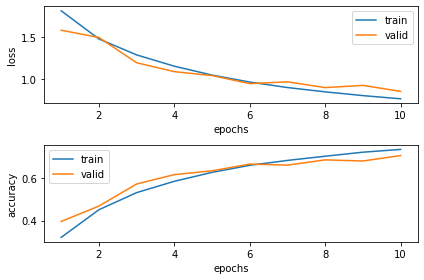

In [46]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [47]:
true_values, pred_values = evaluate(model_6, test_dl)

print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.706
--
confusion matrix
[[809  15  47  21  11   2   5   9  35  46]
 [ 33 833   4   5   3   1   5   6  11  99]
 [ 96   2 599  44  79  47  58  53   6  16]
 [ 35  10  83 495  67 144  75  51  13  27]
 [ 32   5  82  41 629  31  56 109  11   4]
 [ 15   5  56 190  41 542  34 100   7  10]
 [ 10  14  61  56  23  15 801   7   7   6]
 [ 25   4  43  20  48  30   5 804   1  20]
 [139  55  10  11   4   3   5   5 720  48]
 [ 47  70   3  12   2   2   4  19  10 831]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.65      0.81      0.72      1000
  automobile       0.82      0.83      0.83      1000
        bird       0.61      0.60      0.60      1000
         cat       0.55      0.49      0.52      1000
        deer       0.69      0.63      0.66      1000
         dog       0.66      0.54      0.60      1000
        frog       0.76      0.80      0.78      1000
       horse       0.69      0.80      0.74      1000
        ship      

In [48]:
metric_filepath = os.path.join(MODEL_DIR, "model_6.json")
write_metrics(true_values, pred_values, "gradient_clipping", metric_filepath)

### Increase Batch Size

We will increase the batch size from 64 to 128. This will require us to reinstantiate our data loaders.

In [49]:
BATCH_SIZE = 128

train_dl_128 = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl_128 = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

len(train_dl_128), len(test_dl_128)

(391, 79)

In [50]:
model_7 = Cifar10Classifier(
    conv_block_sizes=[32, 64, 64], 
    ff_block_sizes=[64, 10])
summary(model_7, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         Dropout2d-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
              ReLU-6           [-1, 64, 16, 16]               0
         Dropout2d-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,928
             ReLU-10             [-1, 64, 8, 8]               0
        Dropout2d-11             [-1, 64, 8, 8]               0
        MaxPool2d-12             [-1, 64, 4, 4]               0
          Flatten-13                 [-1, 1024]               0
           Linear-14                   

In [51]:
model_7 = model_7.to(dev)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_7.parameters(), lr=LEARNING_RATE)

train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_7, train_dl_128, loss_fn, optimizer)
  val_loss, val_acc = validate(model_7, test_dl_128, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch  1 | Train Loss: 1.834, Accuracy: 0.316 | Validation Loss: 1.530, Accuracy: 0.433
Epoch  2 | Train Loss: 1.453, Accuracy: 0.464 | Validation Loss: 1.336, Accuracy: 0.515
Epoch  3 | Train Loss: 1.321, Accuracy: 0.517 | Validation Loss: 1.291, Accuracy: 0.532
Epoch  4 | Train Loss: 1.227, Accuracy: 0.556 | Validation Loss: 1.175, Accuracy: 0.575
Epoch  5 | Train Loss: 1.144, Accuracy: 0.589 | Validation Loss: 1.132, Accuracy: 0.589
Epoch  6 | Train Loss: 1.069, Accuracy: 0.617 | Validation Loss: 1.066, Accuracy: 0.627
Epoch  7 | Train Loss: 1.005, Accuracy: 0.644 | Validation Loss: 1.002, Accuracy: 0.645
Epoch  8 | Train Loss: 0.946, Accuracy: 0.665 | Validation Loss: 1.017, Accuracy: 0.638
Epoch  9 | Train Loss: 0.903, Accuracy: 0.680 | Validation Loss: 0.929, Accuracy: 0.676
Epoch 10 | Train Loss: 0.869, Accuracy: 0.692 | Validation Loss: 0.948, Accuracy: 0.664


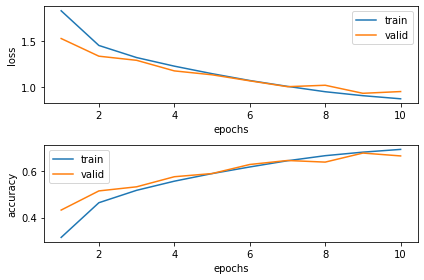

In [52]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [53]:
true_values, pred_values = evaluate(model_7, test_dl)

print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.664
--
confusion matrix
[[613  16  61  22  16   4  14   4 173  77]
 [ 11 741   1  13   1   2  12   2  54 163]
 [ 83   8 491  93  80  52 127  25  23  18]
 [ 10  13  42 560  55  66 152  17  49  36]
 [ 26   3  74  91 542  20 137  76  25   6]
 [ 12   1  55 347  30 420  64  41  16  14]
 [  4   5  23  51  15   5 873   3   8  13]
 [  6   5  22  78  77  62  21 687   4  38]
 [ 24  22   3  19   3   3   5   1 884  36]
 [ 11  62   4  22   1   1  14   7  44 834]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.77      0.61      0.68      1000
  automobile       0.85      0.74      0.79      1000
        bird       0.63      0.49      0.55      1000
         cat       0.43      0.56      0.49      1000
        deer       0.66      0.54      0.60      1000
         dog       0.66      0.42      0.51      1000
        frog       0.62      0.87      0.72      1000
       horse       0.80      0.69      0.74      1000
        ship      

In [54]:
metric_filepath = os.path.join(MODEL_DIR, "model_7.json")
write_metrics(true_values, pred_values, "inc_batch_size", metric_filepath)

## Model Comparison

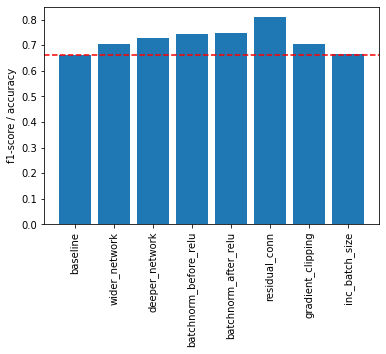

In [55]:
json_files = []
for f in os.listdir(MODEL_DIR):
  if f.endswith(".json"):
    json_files.append(f)

xs, ps, rs, fs = [], [], [], []
for json_file in sorted(json_files):
  with open(os.path.join(MODEL_DIR, json_file), "r") as f:
    metrics_dict = json.loads(f.read())
    xs.append(metrics_dict["name"])
    ps.append(metrics_dict["precision"])
    rs.append(metrics_dict["recall"])
    fs.append(metrics_dict["f1-score"])

plt.bar(np.arange(len(fs)), fs)
plt.ylabel("f1-score / accuracy")
plt.xticks(np.arange(len(fs)), xs, rotation="90")
plt.axhline(fs[0], 0, len(fs), color="r", linestyle="--")
_ = plt.show()

In [56]:
fidx_max, fidx_min = np.argmax(fs), np.argmin(fs)
print("Best results using {:s}: F1-score : {:.3f}".format(
    xs[fidx_max], fs[fidx_max]))
print("Worst results using {:s}: F1-score: {:.3f}".format(
    xs[fidx_min], fs[fidx_min]))

Best results using residual_conn: F1-score : 0.809
Worst results using baseline: F1-score: 0.662
